### Instrucciones generales <a class="tocSkip"></a>
1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio privado de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*
1. Se evaluará 
    1. el **resultado y la calidad de su implementación** en base al último commit antes de la fecha y hora de entrega
    1. su **proceso de desarrollo** en base a su histórico de commits
1. [Sean honestos](https://www.acm.org/about-acm/code-of-ethics-in-spanish)

# Tarea 3: Los K-vecinos 

![vecinos.png](https://i.imgur.com/qi04vM6.png)

Los $K$-vecinos es un método clásico de aprendizaje de máquinas para hacer clasificación

Sea una base de datos $E = \{(x_j, y_j), j=1, \ldots, N\}$, con $N$ ejemplos donde $x_j \in \mathbb{R}^{D}$ es un atributo d-dimensional e $y_j \in \{0, 1, 2, \ldots, C\}$ son sus etiquetas de clase

Sea ahora una segunda base de datos $T = \{(z_i), i=1, \ldots, M\}$ con $M$ ejemplos donde $z_i \in \mathbb{R}^{D}$ es un atributo d-dimensional. Esta base de datos no tiene etiquetas

> Este método clasifica cada elemento de $T$ en base a las etiquetas de sus $K$ ejemplos más cercanos de la base de datos $E$



Para clasificar el i-esimo elemento de Z:
1. Calculamos la distancia entre $z_i$ y cada elemento de $E$ usando
$$
d(z_i, x_j) = \left ( \sum_{d=1}^D  |z_{id} - x_{jd}|^p \right)^{1/p}
$$
1. Buscamos las $k$ tuplas $(x_k^{(i)}, y_k^{(i)})$ con menor distancia a $z_i$
1. Seleccionamos la clase de $z_i$ según
$$
\text{arg}\max_{c=0, 1, \ldots} \sum_{k=1}^K \frac{\mathbb{1}(c=y^{(i)}_k)}{d(z_i, x^{(i)}_k)}
$$
donde 
$$
\mathbb{1}(a=b) = \begin{cases} 1 & \text{si } a=b \\ 0 &  \text{si } a\neq b \end{cases}
$$
se conoce como función indicadora

Esta versión particular del algoritmo se conoce como clasificador de $k$ vecinos ponderado

# Actividades

- Considere la implementación "inocente" del algoritmo KNN que se adjunta a esta tarea con los parámetros $p$ y $k$ por defecto
    - Use la función adjunta `create_data` para crear un conjunto de N=1000 datos
    - Realice un profiling completo de la función `KNN` usando las magias `timeit`, `prun` y `lprun`
    - Reporte sus resultados y comente sobre los cuellos de botella del algoritmo
- Implemente una nueva versión de la función `KNN`
    - Utilice `Cython` con tipos fijos, vistas de arreglos y funciones de la librería estándar matemática de `C`
    - Muestre que obtiene el mismo resultado que la versión original
    - Grafique el *speed-up* de su nueva función con respecto a la implementación "inocente" original para $N=[10, 50, 100, 500, 1000, 5000, 10000]$
- Usando la nueva versión de `KNN` y un conjunto de $1000$ datos creados con `create_data` realice una validación cruzada en el conjunto $E$ para encontrar el mejor valor de los parámetros $k$ y $p$
- Evalue su clasificador en el conjunto $T$ y haga un reporte completo de resultados. Muestre una gráfica de la frontera de decisión de su clasificador en el rango $[(-2,2), (-2,2)]$

**Justifique adecuadamente todas sus decisiones de diseño**

# Ejemplo generación de datos

In [2]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from funciones import create_data, KNN

fig, ax = plt.subplots(figsize=(3, 3), tight_layout=True)
E, T = create_data(N=1000)
x, y = E # Use E para realizar validación cruzada
for c in np.unique(y):
    mask = y == c
    ax.scatter(x[mask, 0], x[mask, 1], label=c, s=5)
z, w = T # Use las etiquetas w para evaluar sus resultados finales
ax.scatter(z[:, 0], z[:, 1], c='k', s=5, marker='x',  alpha=0.2, label='T')
ax.legend();

<IPython.core.display.Javascript object>

```python
%time mi_resultado = mi_funcion(mis_argumentos)

%timeit -r10 -n5 mi_funcion(mis_argumentos)

#retortnar y guardar objeto '-o'
xd = %timeit -r10 -n5 -o mi_funcion(mis_argumentos)

#ademas guardar lo que retorna la funcion a evaluar
xd = %timeit -r10 -n5 -o xdd = mi_funcion(mis_argumentos)

#mide la cantidad de llamadas y el tiempo de cada función
%prun mi_funcion()

#ordenado segun el tiempo acumulado
%prun -s cumtime mi_funcion()

#line profiler
#conda install line_profiler
%load_ext line_profiler

%lprun -f mi_método mi_rutina

#verificar resultados
np.allclose(result1, result2)
```


### KNN de sklearn

Para obtener un objetivo a alcanzar para nuestra versión optimizada de KNN, podemos utilizar `KNeighborsClassifier` de `sklearn.neighbors` y medir su tiempo de ejecución con la misma entrada.
En primer lugar instanciamos el clasificador con las mismas características que la función `KNN inocente` que fue proporcionada:

In [4]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=5, weights='distance',
                             algorithm='brute', p=2, n_jobs=1)

Medimos el tiempo de ajuste y predicción, para luego almacenarlo en la variable `totalTimeSklearn`

In [5]:
%%timeit -r 10 -n 10 -o 
neigh.fit(x, y)
neigh.predict(z)

7.37 ms ± 1.47 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)


<TimeitResult : 7.37 ms ± 1.47 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)>

In [6]:
totalTimeSklearn = _

Comparamos los resultados de las predicciones para los dos algoritmos:

In [7]:
zySklearn = neigh.predict(z)
zy = KNN(x, y, z, k=5, p=2.)
display(np.allclose(zy, zySklearn))
#mask = zy - zySklearn != 0

True

Observamos que la implementación inocente de KNN y el ajuste de KNeighborsClassifier nos entregan las mismas predicciones. Para comparar, medimos el tiempo de ejecución de la implementación naive:

In [8]:
totalTimeNaive = %timeit -r 10 -n 1 -o KNN(x, y, z, k=5, p=2.)

2.29 s ± 338 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)


Si bien no esperamos competir en rendimiento contra una librería especializada, este resultado nos da una idea del potencial speed-up que podríamos alcanzar. Por otra parte, tener disponible una versión rápida nos ayudará al momento de hacer pruebas con nuestras versiones optimizadas, sobretodo cuando queramos verificar que los resultados son correctos y estemos procesandoventradas relativamente grandes, permitiéndonos hacer comparaciones sin tener que esperar tanto tiempo por los resultados de la version inocente.

In [9]:
print(f"speedup knn naive / knn_skl:\n{totalTimeNaive.average / totalTimeSklearn.average : .3f}")

speedup knn naive / knn_skl:
 311.218


### 1- Realice un profiling completo de la función KNN usando las magias timeit, prun y lprun

**Tiempo total de la función KNN con la magia `%timeit` (previamente calculado)**

In [10]:
display(totalTimeNaive)
print(f"min : {totalTimeNaive.best:.3f}[s], max: {totalTimeNaive.worst:.3f}[s]")

<TimeitResult : 2.29 s ± 338 ms per loop (mean ± std. dev. of 10 runs, 1 loop each)>

min : 1.942[s], max: 2.921[s]


El tiempo que tarda la implementación inocente en ajustar y predecir para una entrada de tanaño N=1000 varía entre 1 y 20 segundos dependiendo de la máquina en la que realicemos las pruebas

**Cantidad de llamadas y el tiempo de cada función ejecutada por `KNN` utilizando la magia `%prun`**

In [11]:
%prun -s tottime KNN(x, y, z, k=5, p=2.)

De este profiling se observa la gran cantidad de funciones que son llamadas dentro del primer ciclo for anidado, o sea, la linea 21 de `funciones.py` que se ejecuta N * M veces.


```python
dist[i, j] = np.power(np.sum(np.power(np.absolute(Z[i] - X[j]), p)), 1./p)
```

Probablemente sea esta linea el principal contribuyente al tiempo que tarda el algoritmo.

Aparte del primer ciclo for anidado destaca la linea  `  1    0.012    0.012    0.012    0.012 {method 'argsort' of 'numpy.ndarray' objects}` con el mayor tiempo por llamada, sin embargo sólo se llama una vez, por lo que no nos parece la mejor opción enfocar nuestros esfuerzos en la implementación de un algoritmo argsort que nos ofrecerá una mejora marginal en comparación a optimizar la sección que se ejecuta muchas veces.

**Profiling línea a línea con `%lprun`**

In [12]:
%load_ext line_profiler

In [13]:
lineProf = %lprun -r -f KNN KNN(x, y, z, k=5, p=2.)

In [14]:
lineProf.print_stats()

Timer unit: 1e-07 s

Total time: 5.29226 s
File: C:\Users\josenoob\Desktop\INFO147\INFO147_TAREA03\funciones.py
Function: KNN at line 14

Line #      Hits         Time  Per Hit   % Time  Line Contents
    14                                           def KNN(X, Y, Z, k=5, p=2.):
    15         1       1858.0   1858.0      0.0      C = np.unique(Y)
    16         1         27.0     27.0      0.0      N, D = X.shape
    17         1         16.0     16.0      0.0      M, _ = Z.shape
    18         1        330.0    330.0      0.0      dist = np.zeros(shape=(M, N))
    19       751       5986.0      8.0      0.0      for i in range(M):
    20    188250    2148512.0     11.4      4.1          for j in range(N):
    21    187500   50198662.0    267.7     94.9              dist[i, j] = np.power(np.sum(np.power(np.absolute(Z[i] - X[j]), p)), 1./p)
    22         1      83289.0  83289.0      0.2      neighbours = np.argsort(dist, axis=1)[:, :k]
    23         1        122.0    122.0      0.0   

Como sospechábamos, un enorme margen del tiempo total de ejecución se debe a la línea que calcula y almacena la distancia entre cada par de datos que, junto a su respectivo `for` **acumulan cerca del 98% del total del tiempo de ejecución:**


```python
20) for j in range(N):
21)    dist[i, j] = np.power(np.sum(np.power(np.absolute(Z[i] - X[j]), p)), 1./p)
```


Principalmente la línea (21) con más del 94% del total, línea que llamó nuestra atención en el profiling previo por todas las llamadas a funciones que realiza debido a los numerosos cálculos matemáticos complejos que efectúa.

```python
27) for j in range(N):
    criterion[c] = np.sum(1./dist[i, neighbours[i]][Y[neighbours[i]] == c])
```

Del mismo modo intentaremos optimizar la línea 27 que se encuentra en segundo lugar en tiempo total, aunque su tiempo de ejecución parezca despreciable si lo comparamos con el de la línea 21.

Con esto en mente, buscaremos optimizar la problemática línea 21, y la función en general, con el fin de reducir el tiempo de ejecución del algoritmo. Para esto, utilizaremos **Cython** aplicando las mejoras que aprendimos en el curso como el uso de **tipos estáticos** y de **funciones nativas de C** para los cálculos matemáticos.

Esperamos que, a medida que optimicemos ciertas secciones del código, descubramos otros cuellos de botella u otras partes que nos entreguen mejoras menores en rendimiento.

In [15]:
%load_ext cython

In [16]:
from Cython.Compiler import Options
Options.get_directive_defaults()['profile'] = True
Options.get_directive_defaults()['linetrace'] = True
Options.get_directive_defaults()['binding'] = True

%%cython -a --compile-args=-DCYTHON_TRACE=1 --force

In [17]:
%%cython --compile-args=-DCYTHON_TRACE=1 --force
import numpy as np
cimport cython
cimport numpy as npc

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO_i
TIPI = np.int64

cdef extern from "math.h":
    TIPO_t pow(TIPO_t, TIPO_t)
    TIPO_t fabs(TIPO_t)

@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def KNN_Cython(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    
    Cn = np.unique(Y)
    cdef:
        TIPO_i [::1] C = Cn
        int nUniques = Cn.shape[0]
        Py_ssize_t N = X.shape[0]
        Py_ssize_t D = X.shape[1]
        Py_ssize_t M = Z.shape[0]
        Py_ssize_t i, j, l
        TIPO_t exponent = 1/p
        
    dist = np.zeros(shape=(M, N), dtype=TIPO)
    cdef TIPO_t [:, ::1] dist_view = dist
        
    for i in range(M):
        for j in range(N):
            for l in range(D):
                dist_view[i, j] += pow(fabs(Z[i][l] - X[j][l]), p)
            dist_view[i, j] = pow(dist_view[i, j], exponent)

    neighbros = np.asarray(np.argsort(dist_view, axis=1)[:, :k], order='C')
    Zz_Y = np.zeros(shape=(M, ), dtype=TIPI)
    
    cdef:
        TIPO_i [:, ::1] neighbours = neighbros
        TIPO_i [::1] Z_Y = Zz_Y
        TIPO_t valmax, criterion
        
    for i in range(M):
        valmax = 0.
        for j in range(nUniques):
            criterion = 0.
            for l in range(k):
                criterion += (Y[neighbours[i][l]] == C[j])/(dist_view[i, neighbours[i][l]])
            if valmax < criterion:
                Z_Y[i] = j
                valmax = criterion
    return Zz_Y

In [18]:
%%cython -a -c=-DCYTHON_TRACE=1 --force
import numpy as np
cimport cython
cimport numpy as npc
from libc.stdlib cimport qsort

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO_i
TIPI = np.int64

cdef extern from "math.h":
    TIPO_t pow(TIPO_t, TIPO_t)
    TIPO_t fabs(TIPO_t)
    
cdef struct IndexedDist:
    TIPO_t value;
    TIPO_i index;   

cdef IndexedDist make_item(TIPO_t value, TIPO_i index):
    cdef IndexedDist foo 
    foo.value = value
    foo.index = index
    return foo    
    
cdef int cmp_func(const void* a, const void* b) nogil:
    return ((<IndexedDist*>a).value > (<IndexedDist*>b).value) - ((<IndexedDist*>a).value < (<IndexedDist*>b).value)
  
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def KNN_C(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    
    Cn = np.unique(Y)
    cdef:
        TIPO_i [::1] C = Cn
        int nUniques = Cn.shape[0]
        Py_ssize_t N = X.shape[0]
        Py_ssize_t D = X.shape[1]
        Py_ssize_t M = Z.shape[0]
        Py_ssize_t i, j, l
        TIPO_t exponent = 1/p
        size_t tamano = sizeof(IndexedDist)
    
    dist = np.empty(shape=(M, N), dtype=[('value', TIPO), ('index', TIPI)])
    cdef IndexedDist [:, ::1] dist_view = dist
    
    for i in range(M):
        for j in range(N):
            dist_view[i, j] = make_item(pow(fabs(Z[i, 0] - X[j, 0]), p), j)
            for l in range(1, D):
                dist_view[i, j].value += pow(fabs(Z[i, l] - X[j, l]), p)
            dist_view[i, j].value = pow(dist_view[i, j].value, exponent)

    for i in range(M):
        qsort(&dist_view[i][0], N, tamano, cmp_func)
    
    Zz_Y = np.empty(shape=(M, ), dtype=TIPI)
    
    cdef:
        TIPO_i [::1] Z_Y = Zz_Y
        TIPO_t valmax, criterion
        
    for i in range(M):
        valmax = 0.
        for j in range(nUniques):
            criterion = 0.
            for l in range(k):
                criterion += (Y[dist_view[i][l].index] == C[j])/(dist_view[i, l].value)
            if valmax < criterion:
                Z_Y[i] = j
                valmax = criterion
    return Zz_Y

In [19]:
%%cython -a -+ -c=-DCYTHON_TRACE=1 --force
import numpy as np
cimport cython
cimport numpy as npc
from cython.parallel import prange
from libcpp.algorithm cimport sort as stdsort
from libcpp cimport bool

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO_i
TIPI = np.int64

cdef extern from "math.h" nogil:
    TIPO_t pow(TIPO_t, TIPO_t)
    TIPO_t fabs(TIPO_t)
    
cdef struct IndexedDist:
    TIPO_t value;
    TIPO_i index;
    
cdef bool comp(IndexedDist a, IndexedDist b):
    return (a.value > b.value)   

cdef IndexedDist make_item(TIPO_t value, TIPO_i index):
    cdef IndexedDist foo
    foo.value = value
    foo.index = index
    return foo    
      
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def KNN_CPP(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    
    Cn = np.unique(Y)
    cdef:
        TIPO_i [::1] C = Cn
        int nUniques = Cn.shape[0]
        Py_ssize_t N = X.shape[0]
        Py_ssize_t D = X.shape[1]
        Py_ssize_t M = Z.shape[0]
        Py_ssize_t i, j, l
        TIPO_t exponent = -1/p
    
    dist = np.empty(shape=(M, N), dtype=[('value', TIPO), ('index', TIPI)])
    cdef IndexedDist [:, ::1] dist_view = dist
    
    for i in range(M):
        for j in range(N):
            dist_view[i, j] = make_item(pow(fabs(Z[i, 0] - X[j, 0]), p), j)
            for l in range(1, D):
                dist_view[i, j].value += pow(fabs(Z[i, l] - X[j, l]), p)
            dist_view[i, j].value = pow(dist_view[i, j].value, exponent)

    for i in range(M):
        stdsort(&(dist_view[i][0]), (&(dist_view[i][0])) +  N, comp)
    
    Zz_Y = np.empty(shape=(M, ), dtype=TIPI)
    
    cdef:
        TIPO_i [::1] Z_Y = Zz_Y
        TIPO_t valmax, criterion
        
    for i in range(M):
        valmax = 0.
        for j in range(nUniques):
            criterion = 0.
            for l in range(k):
                criterion += (Y[dist_view[i][l].index] == C[j])*(dist_view[i, l].value)
            if valmax < criterion:
                Z_Y[i] = j
                valmax = criterion
    return Zz_Y

In [20]:
%%cython -a -c=-DCYTHON_TRACE=1 -c=-fopenmp --link-args=-fopenmp --force
import numpy as np
cimport cython
cimport numpy as npc
from libc.stdlib cimport qsort
from cython.parallel import prange

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO_i
TIPI = np.int64

cdef extern from "math.h" nogil:
    TIPO_t pow(TIPO_t, TIPO_t)
    TIPO_t fabs(TIPO_t)
    
cdef struct IndexedDist:
    TIPO_t value;
    TIPO_i index;   

cdef IndexedDist make_item(TIPO_t value, TIPO_i index) nogil:
    cdef IndexedDist foo 
    foo.value = value
    foo.index = index
    return foo    
    
cdef int cmp_func(const void* a, const void* b) nogil:
    return ((<IndexedDist*>a).value > (<IndexedDist*>b).value) - ((<IndexedDist*>a).value < (<IndexedDist*>b).value)
  
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def KNN_C_par(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    
    Cn = np.unique(Y)
    cdef:
        TIPO_i [::1] C = Cn
        int nUniques = Cn.shape[0]
        Py_ssize_t N = X.shape[0]
        Py_ssize_t D = X.shape[1]
        Py_ssize_t M = Z.shape[0]
        Py_ssize_t i, j, l
        TIPO_t exponent = 1/p
        size_t tamano = sizeof(IndexedDist)
    
    dist = np.empty(shape=(M, N), dtype=[('value', TIPO), ('index', TIPI)])
    cdef IndexedDist [:, ::1] dist_view = dist
    
    with nogil:
        for i in prange(M, num_threads=4):
            for j in range(N):
                dist_view[i, j] = make_item(pow(fabs(Z[i, 0] - X[j, 0]), p), j)
                for l in range(1, D):
                    dist_view[i, j].value += pow(fabs(Z[i, l] - X[j, l]), p)
                dist_view[i, j].value = pow(dist_view[i, j].value, exponent)

    with nogil:
        for i in prange(M, num_threads=4):
            qsort(&dist_view[i][0], N, tamano, cmp_func)
    
    Zz_Y = np.empty(shape=(M, ), dtype=TIPI)
    
    cdef:
        TIPO_i [::1] Z_Y = Zz_Y
        TIPO_t valmax, criterion
        
    for i in range(M):
        valmax = 0.
        for j in range(nUniques):
            criterion = 0.
            for l in range(k):
                criterion += (Y[dist_view[i][l].index] == C[j])/(dist_view[i, l].value)
            if valmax < criterion:
                Z_Y[i] = j
                valmax = criterion
    return Zz_Y

In [21]:
%%cython -a -+ -c=-DCYTHON_TRACE=1 -c=-fopenmp --link-args=-fopenmp --force
import numpy as np
cimport cython
cimport numpy as npc
from cython.parallel import prange
from libcpp.algorithm cimport sort as stdsort
from libcpp cimport bool

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO_i
TIPI = np.int64

cdef extern from "math.h" nogil:
    TIPO_t pow(TIPO_t, TIPO_t)
    TIPO_t fabs(TIPO_t)
    
cdef struct IndexedDist:
    TIPO_t value;
    TIPO_i index;
    
cdef bool comp(IndexedDist a, IndexedDist b) nogil:
    return (a.value < b.value)   

cdef IndexedDist make_item(TIPO_t value, TIPO_i index) nogil:
    cdef IndexedDist foo
    foo.value = value
    foo.index = index
    return foo    
      
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def KNN_CPP_par(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    
    Cn = np.unique(Y)
    cdef:
        TIPO_i [::1] C = Cn
        int nUniques = Cn.shape[0]
        Py_ssize_t N = X.shape[0]
        Py_ssize_t D = X.shape[1]
        Py_ssize_t M = Z.shape[0]
        Py_ssize_t i, j, l
        TIPO_t exponent = 1/p
    
    dist = np.empty(shape=(M, N), dtype=[('value', TIPO), ('index', TIPI)])
    cdef IndexedDist [:, ::1] dist_view = dist
    
    with nogil:
        for i in prange(M, num_threads=4):
            for j in range(N):
                dist_view[i, j] = make_item(pow(fabs(Z[i, 0] - X[j, 0]), p), j)
                for l in range(1, D):
                    dist_view[i, j].value += pow(fabs(Z[i, l] - X[j, l]), p)
                dist_view[i, j].value = pow(dist_view[i, j].value, exponent)
        
    with nogil:
        for i in prange(M, num_threads=4):
            stdsort(&dist_view[i][0], (&(dist_view[i][0])) +  N, comp)
    
    Zz_Y = np.empty(shape=(M, ), dtype=TIPI, order='C')
    cdef:
        TIPO_i [::1] Z_Y = Zz_Y
        TIPO_t valmax, criterion
        
    for i in range(M):
        valmax = 0.
        for j in range(nUniques):
            criterion = 0.
            for l in range(k):
                criterion += (Y[dist_view[i][l].index] == C[j])/(dist_view[i, l].value)
            if valmax < criterion:
                Z_Y[i] = j
                valmax = criterion
    return Zz_Y

In [22]:
%%cython -a -c=-DCYTHON_TRACE=1 -c=-fopenmp --link-args=-fopenmp --force
import numpy as np
cimport cython
cimport numpy as npc
from libc.stdlib cimport qsort
from cython.parallel import prange

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO_i
TIPI = np.int64

cdef extern from "math.h" nogil:
    TIPO_t pow(TIPO_t, TIPO_t)
    TIPO_t fabs(TIPO_t)
    
cdef struct IndexedDist:
    TIPO_t value;
    TIPO_i index;   

cdef IndexedDist make_item(TIPO_t value, TIPO_i index) nogil:
    cdef IndexedDist foo 
    foo.value = value
    foo.index = index
    return foo    
    
cdef int cmp_func(const void* a, const void* b) nogil:
    return ((<IndexedDist*>a).value > (<IndexedDist*>b).value) - ((<IndexedDist*>a).value < (<IndexedDist*>b).value)
  
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def KNN_C_fullparallel(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    
    Cn = np.unique(Y)
    cdef:
        TIPO_i [::1] C = Cn
        int nUniques = Cn.shape[0]
        Py_ssize_t N = X.shape[0]
        Py_ssize_t D = X.shape[1]
        Py_ssize_t M = Z.shape[0]
        Py_ssize_t i, j, l
        TIPO_t exponent = 1/p
        size_t tamano = sizeof(IndexedDist)
    
    dist = np.empty(shape=(M, N), dtype=[('value', TIPO), ('index', TIPI)])
    cdef IndexedDist [:, ::1] dist_view = dist
    
    with nogil:
        for i in prange(M, num_threads=4):
            for j in range(N):
                dist_view[i, j] = make_item(pow(fabs(Z[i, 0] - X[j, 0]), p), j)
                for l in range(1, D):
                    dist_view[i, j].value += pow(fabs(Z[i, l] - X[j, l]), p)
                dist_view[i, j].value = pow(dist_view[i, j].value, exponent)

    with nogil:
        for i in prange(M, num_threads=4):
            qsort(&dist_view[i][0], N, tamano, cmp_func)
    
    Zz_Y = np.empty(shape=(M, ), dtype=TIPI)
    vm = np.empty(shape=(M, ), dtype=TIPO)
    crit = np.empty(shape=(M, ), dtype=TIPO)
    
    cdef:
        TIPO_i [::1] Z_Y = Zz_Y
        TIPO_t [::1] valmax = vm
        TIPO_t [::1] criterion = crit
        
    with nogil:
        for i in prange(M, num_threads=4):
            valmax[i] = 0.
            for j in range(nUniques):
                criterion[i] = 0.
                for l in range(k):
                    criterion[i] += (Y[dist_view[i][l].index] == C[j])/(dist_view[i, l].value)
                if valmax[i] < criterion[i]:
                    Z_Y[i] = j
                    valmax[i] = criterion[i]
    return Zz_Y

In [23]:
%%cython -a -+ -c=-DCYTHON_TRACE=1 -c=-fopenmp --link-args=-fopenmp --force
import numpy as np
cimport cython
cimport numpy as npc
from cython.parallel import prange
from libcpp.algorithm cimport sort as stdsort
from libcpp cimport bool

ctypedef npc.float64_t TIPO_t
TIPO = np.float64

ctypedef npc.int64_t TIPO_i
TIPI = np.int64

cdef extern from "math.h" nogil:
    TIPO_t pow(TIPO_t, TIPO_t)
    TIPO_t fabs(TIPO_t)
    
cdef struct IndexedDist:
    TIPO_t value;
    TIPO_i index;
    
cdef bool comp(IndexedDist a, IndexedDist b) nogil:
    return (a.value < b.value)   

cdef IndexedDist make_item(TIPO_t value, TIPO_i index) nogil:
    cdef IndexedDist foo
    foo.value = value
    foo.index = index
    return foo    
      
@cython.boundscheck(False)
@cython.wraparound(False)
@cython.cdivision(True)
def KNN_CPP_fullparallel(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    
    Cn = np.unique(Y)
    cdef:
        TIPO_i [::1] C = Cn
        int nUniques = Cn.shape[0]
        Py_ssize_t N = X.shape[0]
        Py_ssize_t D = X.shape[1]
        Py_ssize_t M = Z.shape[0]
        Py_ssize_t i, j, l
        TIPO_t exponent = 1/p
        size_t tamano = sizeof(IndexedDist)
    
    dist = np.empty(shape=(M, N), dtype=[('value', TIPO), ('index', TIPI)])
    cdef IndexedDist [:, ::1] dist_view = dist
    
    with nogil:
        for i in prange(M, num_threads=4):
            for j in range(N):
                dist_view[i, j] = make_item(pow(fabs(Z[i, 0] - X[j, 0]), p), j)
                for l in range(1, D):
                    dist_view[i, j].value += pow(fabs(Z[i, l] - X[j, l]), p)
                dist_view[i, j].value = pow(dist_view[i, j].value, exponent)

    with nogil:
        for i in prange(M, num_threads=4):
            stdsort(&(dist_view[i][0]), (&(dist_view[i][0])) +  N, comp)
    
    Zz_Y = np.zeros(shape=(M, ), dtype=TIPI)
    vmax = np.zeros(shape=(M, ), dtype=TIPO)
    crit = np.empty(shape=(M, ), dtype=TIPO)
    
    cdef:
        TIPO_i [::1] Z_Y = Zz_Y
        TIPO_t [::1] valmax = vmax
        TIPO_t [::1] criterion = crit
        
    with nogil:
        for i in prange(M, num_threads=4):
            for j in range(nUniques):
                criterion[i] = 0.
                for l in range(k):
                    criterion[i] += (Y[dist_view[i][l].index] == C[j])/(dist_view[i, l].value + 0.00001)
                if valmax[i] < criterion[i]:
                    Z_Y[i] = j
                    valmax[i] = criterion[i]
    return Zz_Y

In [24]:
E, T = create_data(N=1000)
x, y = E
z, _ = T

neigh = KNeighborsClassifier(n_neighbors=5, weights='distance',
                             algorithm='brute', p=2, n_jobs=1)
neigh.fit(x, y)

KNeighborsClassifier(algorithm='brute', n_jobs=1, weights='distance')

In [25]:
#%timeit -r 10 -n 1 KNN(x, y, z, k=5, p=2.)
functions = [KNN_Cython, KNN_C, KNN_CPP, KNN_C_par, KNN_CPP_par,
            KNN_C_fullparallel, KNN_CPP_fullparallel]
kvalue = 5
pvalue = 2.
nz = neigh.predict(z)
sep = "-"*70
ac = "AllClose?"
msj = "Comparando contra el resultado de KNeighborsClassifier"
print(f"{msj:^70}")
print(sep)
for fun in functions:
    print(f"      Funcion: {fun.func_name:<25} - {ac:>17} " +
          f"{np.allclose(nz, fun(x, y, z, k=kvalue, p=pvalue))}")
    %timeit -r 10 fun(x, y, z, k=kvalue, p=pvalue)
    print(sep)

print("\t\t    KNeighborsClassifier predict")
%timeit -r 10 neigh.predict(z)
print(sep)
print("listo")

        Comparando contra el resultado de KNeighborsClassifier        
----------------------------------------------------------------------
      Funcion: KNN_Cython                -         AllClose? True
21.5 ms ± 1.81 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
----------------------------------------------------------------------
      Funcion: KNN_C                     -         AllClose? True
32.9 ms ± 3.05 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
----------------------------------------------------------------------
      Funcion: KNN_CPP                   -         AllClose? True
49.2 ms ± 1.35 ms per loop (mean ± std. dev. of 10 runs, 10 loops each)
----------------------------------------------------------------------
      Funcion: KNN_C_par                 -         AllClose? True
16 ms ± 1.62 ms per loop (mean ± std. dev. of 10 runs, 100 loops each)
----------------------------------------------------------------------
      Funcion: KNN_CPP_

In [26]:
import line_profiler
profile = line_profiler.LineProfiler(KNN_Cython)
profile.runcall(KNN_Cython, x, y, z, k=5, p=2.)
profile.print_stats()

Timer unit: 1e-07 s

Total time: 0.296395 s
File: C:\Users\josenoob\.ipython\cython\_cython_magic_1f301d2e05a2889c8c1bc6b7d6daa606.pyx
Function: KNN_Cython at line 18

Line #      Hits         Time  Per Hit   % Time  Line Contents
    18                                           def KNN_Cython(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    19                                               
    20         1       2375.0   2375.0      0.1      Cn = np.unique(Y)
    21                                               cdef:
    22         1         79.0     79.0      0.0          TIPO_i [::1] C = Cn
    23         1         12.0     12.0      0.0          int nUniques = Cn.shape[0]
    24         1          7.0      7.0      0.0          Py_ssize_t N = X.shape[0]
    25         1          6.0      6.0      0.0          Py_ssize_t D = X.shape[1]
    26         1          4.0      4.0      0.0          Py_ssize_t M = Z.shape[0]
    27                        

In [27]:
profileC = line_profiler.LineProfiler(KNN_C)
profileC.runcall(KNN_C, x, y, z, k=5, p=2.)
profileC.print_stats()

Timer unit: 1e-07 s

Total time: 0.339867 s
File: C:\Users\josenoob\.ipython\cython\_cython_magic_a2e72e38fbc233b44b391926103f00cb.pyx
Function: KNN_C at line 32

Line #      Hits         Time  Per Hit   % Time  Line Contents
    32                                           def KNN_C(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    33                                               
    34         1      27481.0  27481.0      0.8      Cn = np.unique(Y)
    35                                               cdef:
    36         1        187.0    187.0      0.0          TIPO_i [::1] C = Cn
    37         1         15.0     15.0      0.0          int nUniques = Cn.shape[0]
    38         1          6.0      6.0      0.0          Py_ssize_t N = X.shape[0]
    39         1          4.0      4.0      0.0          Py_ssize_t D = X.shape[1]
    40         1          6.0      6.0      0.0          Py_ssize_t M = Z.shape[0]
    41                                  

In [28]:
profileCPP = line_profiler.LineProfiler(KNN_CPP)
profileCPP.runcall(KNN_CPP, x, y, z, k=5, p=2.)
profileCPP.print_stats()

Timer unit: 1e-07 s

Total time: 0.649178 s
File: C:\Users\josenoob\.ipython\cython\_cython_magic_6596561a31c0978e0ab09f94d640cc97.pyx
Function: KNN_CPP at line 34

Line #      Hits         Time  Per Hit   % Time  Line Contents
    34                                           def KNN_CPP(TIPO_t [:, ::1] X, TIPO_i [::1] Y, TIPO_t [:, ::1] Z, int k=5, TIPO_t p=2.):    
    35                                               
    36         1      22173.0  22173.0      0.3      Cn = np.unique(Y)
    37                                               cdef:
    38         1        150.0    150.0      0.0          TIPO_i [::1] C = Cn
    39         1         14.0     14.0      0.0          int nUniques = Cn.shape[0]
    40         1          6.0      6.0      0.0          Py_ssize_t N = X.shape[0]
    41         1          5.0      5.0      0.0          Py_ssize_t D = X.shape[1]
    42         1          5.0      5.0      0.0          Py_ssize_t M = Z.shape[0]
    43                              

Grafique el speed-up de su nueva función con respecto a la implementación "inocente" original para 𝑁=[10,50,100,500,1000,5000,10000]

In [29]:
nValues = [50, 100, 500, 1000, 5000, 10000]
#nValues = [50, 100, 500]
#la primera funcion debe ser la knn inocente
functions = [KNN, KNN_C, KNN_CPP, KNN_C_par, KNN_CPP_par, neigh.predict]
timeResults = np.empty(shape=(len(functions), len(nValues)))
stdResults = np.empty(shape=(len(functions), len(nValues)))
for j, nVal in enumerate(nValues):
    E, T = create_data(N=nVal)
    x, y = E
    z, _ = T
    neigh.fit(x, y)
    print(f"profileando para entrada de tamaño {nVal} ...")
    for i, fun in enumerate(functions):
        if fun == KNN and nVal > 1000:
            timeR = %timeit -r 1 -n 1 -o -q fun(x, y, z, k=5, p=2.)
        elif (fun == neigh.predict):
            timeR = %timeit -r 5 -o -q fun(z)
        else:
            timeR = %timeit -r 5 -o -q fun(x, y, z, k=5, p=2.)
            
        timeResults[i][j] = timeR.average
        stdResults[i][j] = timeR.stdev

profileando para entrada de tamaño 50 ...
profileando para entrada de tamaño 100 ...
profileando para entrada de tamaño 500 ...
profileando para entrada de tamaño 1000 ...
profileando para entrada de tamaño 5000 ...
profileando para entrada de tamaño 10000 ...


In [30]:
#la primera funcion debe ser la knn inocente
speedUp = np.empty(shape=(len(functions), len(nValues)))
for j, nval in enumerate(nValues):
    for i, fun in enumerate(functions):
        speedUp[i][j] = (timeResults[0][j]/ timeResults[i][j])

<IPython.core.display.Javascript object>


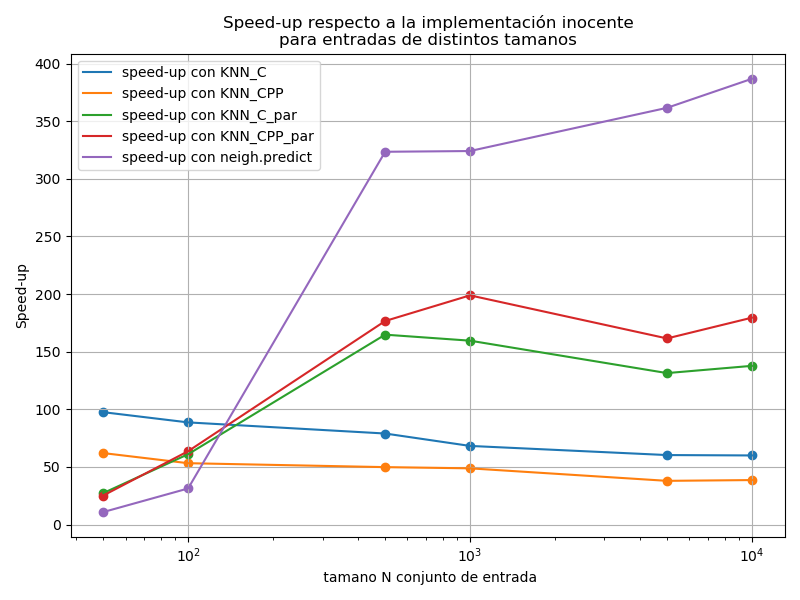

In [36]:
fig, ax = plt.subplots(tight_layout=True, figsize=(8, 6))
for i in range(1, speedUp.shape[0] - 1):
    lb = "speed-up con " + functions[i].func_name
    ax.plot(nValues, speedUp[i], label=lb)
    ax.scatter(nValues, speedUp[i])
    #ax.errorbar(nValues, speedUp[i], yerr=(stdResults[i]))
    
lb = "speed-up con neigh.predict"
ax.plot(nValues, speedUp[-1], label=lb)
ax.scatter(nValues, speedUp[-1])
    
ax.set_title("Speed-up respecto a la implementación inocente\npara entradas de distintos tamanos")
ax.set_ylabel("Speed-up")
ax.set_xlabel(" tamano N conjunto de entrada")
ax.legend()
ax.set_xticks(nValues)
ax.set_xscale('log')
ax.grid()

### Usando la nueva versión de `KNN` y un conjunto de $1000$ datos creados con `create_data` realice una validación cruzada en el conjunto $E$ para encontrar el mejor valor de los parámetros $k$ y $p$###

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

E, T = create_data(N=1000)
x, y = E
z, _ = T

def validacionInline(fun):
    kf = KFold(n_splits=5) # 5 particiones
    pvalues = np.linspace(0.1, 15, num=150)
    scores = [[], [], [], []]
    for pv in pvalues:
        for kval in range(1, 20):
            score = np.zeros(shape=(kf.get_n_splits(), ))
            for i, (train_index, valid_index) in enumerate(kf.split(x)):
                cm = confusion_matrix(y[valid_index],
                                     (fun(x[train_index],
                                          y[train_index],
                                          x[valid_index], 
                                          k=kval, p=pv)))
                score[i] = np.sum(np.diag(cm)) / np.sum(cm)
            for i, att in enumerate([pv, kval, np.mean(score), np.std(score)]):
                scores[i].append(att)

    idx = np.argmax(scores[2])
    bestParams = {}
    for listas, att in zip (scores, ["p", "k", "score", "std"]):
        bestParams[att] = listas[idx]
    print(bestParams)
    return bestParams

In [37]:
#functions = [KNN, KNN_C, KNN_CPP, KNN_C_par, KNN_CPP_par, neigh.predict]
bestT = 9999
for fun in functions[1:-1]:
    print(fun.func_name)
    timeV = %timeit -r 1 -n 1 -o validacionInline(fun)
    if (timeV.average < bestT):
        bestT = timeV.average
        bestFun = fun
    print(sep)
print(f"la mejor funcion para la validacion es {bestFun.func_name} con un tiempo promedio de {bestT}[s]")

KNN_C


KeyboardInterrupt: 

El mejor valor de los parámetros  𝑘  y  𝑝 son 1 y 13 respectivamente con una correctitud de 0.952 y desviacion estandar $\approx$ 0.02713

<IPython.core.display.Javascript object>


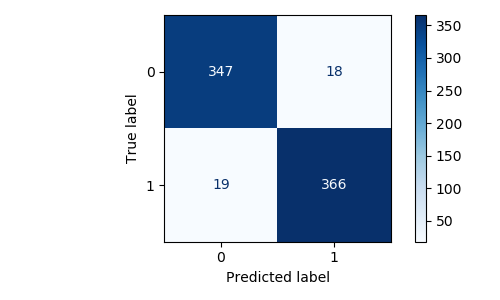

In [35]:
from sklearn.metrics import ConfusionMatrixDisplay

bestParams = validacionInline(KNN_CPP_par)
fig, ax3 = plt.subplots(figsize=(5, 3), tight_layout=True)
ypred = KNN_CPP_par(x, y, z, k=bestParams.get("k"), p=bestParams.get("p"))
cm = confusion_matrix(w, ypred)                     
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.array(['0', '1']))
disp = disp.plot(include_values=True,
                 cmap=plt.cm.Blues, ax=ax3)

plt.show()

-Hay 18 casos predichos como 1 que en realidad eran 0

-Hay 19 casos predichos como 0 que en realidad eran 1